In [1]:
# PREREQUISITES
# We have some real data examples with mean values. We also have python script that determinate the distribution. Let's see result.

In [2]:
# IMPORT LIBRARIES
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# IMPORT DATA
# 100 samples with 700 observations in each
data_frame = pd.read_csv('/Users/mitya/Downloads/cr_export.csv', sep=',', header=None)
bounce_rate = data_frame[0]
page_view = data_frame[1]
cr_order = data_frame[2]
cr_all_forms = data_frame[3]

# 100 samples with 10 000 observations in each
data_frame = pd.read_csv('/Users/mitya/Downloads/cr_export_1.csv', sep=',', header=None)
bounce_rate_1 = data_frame[0]
page_view_1 = data_frame[1]

# 500 samples with ~ 700 observations in each
data_frame_2 = pd.read_csv('/Users/mitya/Downloads/cr_export_2.csv', sep=',', header=None)
bounce_rate_2 = data_frame_2[0]

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

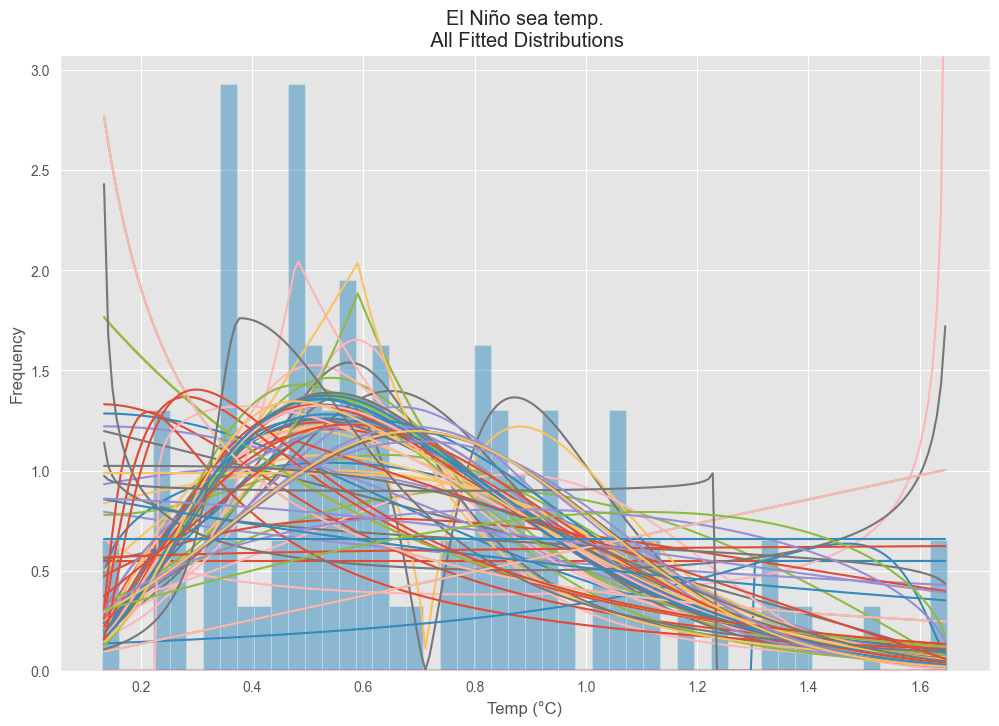

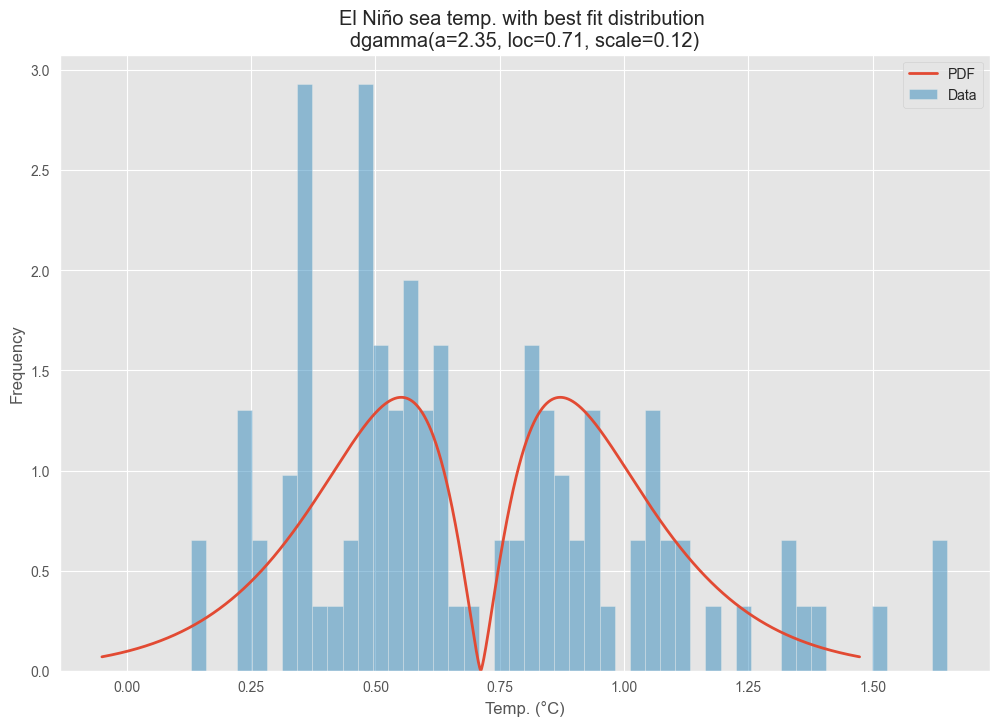

In [4]:
# CALCULATIONS
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])


def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


# Load data from statsmodels datasets
data = cr_order

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12, 8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
# CONCLUSIONS
# In most examples, we did not get a normal or binomial distribution. Options: erroneous data, small sample sizes, non-working script.
# Let's try to generate a normal distribution data, then test the script.

# Exceptions
# The bounce rate has a double gamma distribution close to normal.

In [ ]:
normal_distribution_data = np.random.normal(12, 2, 500)
normal_distribution_data = pd.Series(normal_distribution_data)
print(normal_distribution_data)

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

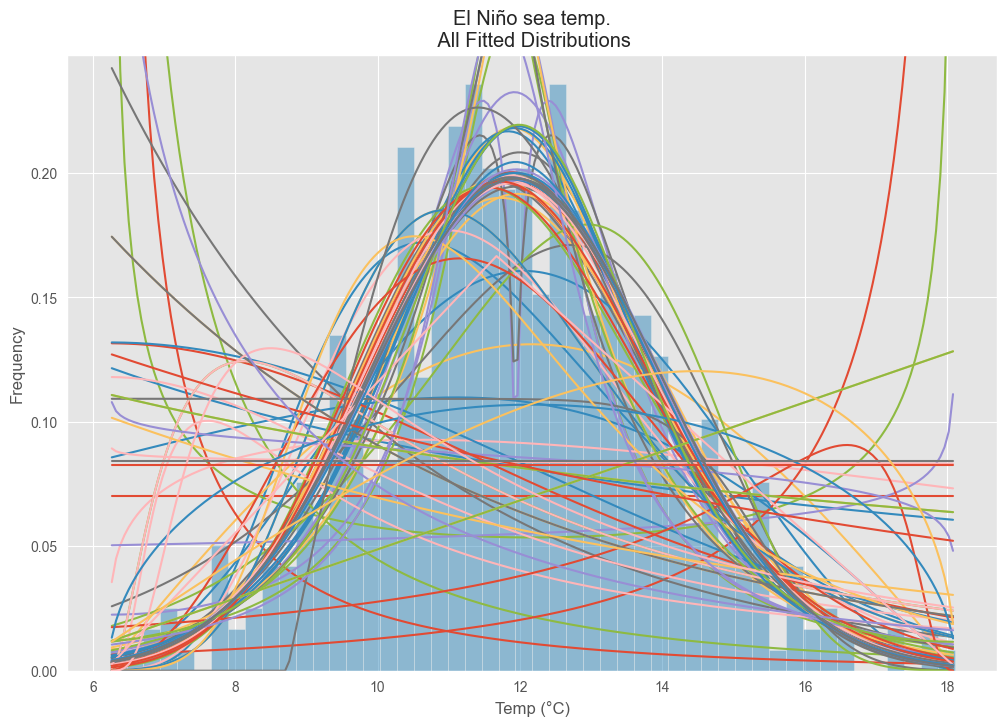

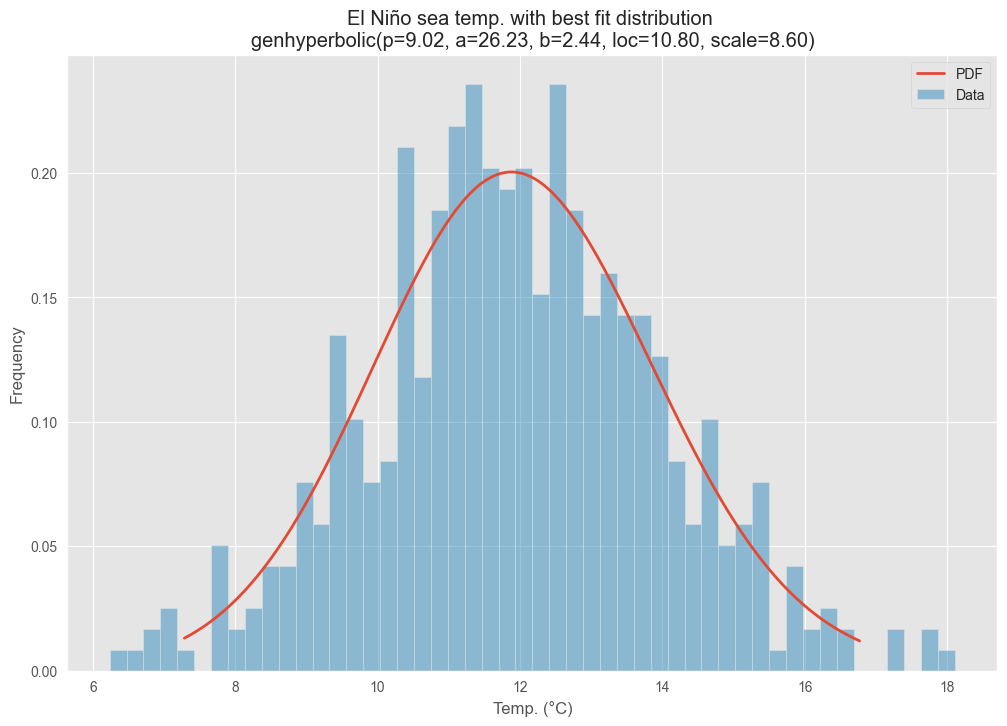

In [19]:
# CALCULATIONS
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])


def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


# Load data from statsmodels datasets
data = normal_distribution_data

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12, 8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
# We got generalised hyperbolic distribution, one of the options of normal distribution. The script works correct.

In [25]:
binomial_distribution_data = []
for _ in range(10000):
    mean_generator = np.random.binomial(1, 0.3, 1000).mean()
    binomial_distribution_data.append(mean_generator)
binomial_distribution_data = pd.Series(binomial_distribution_data)

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

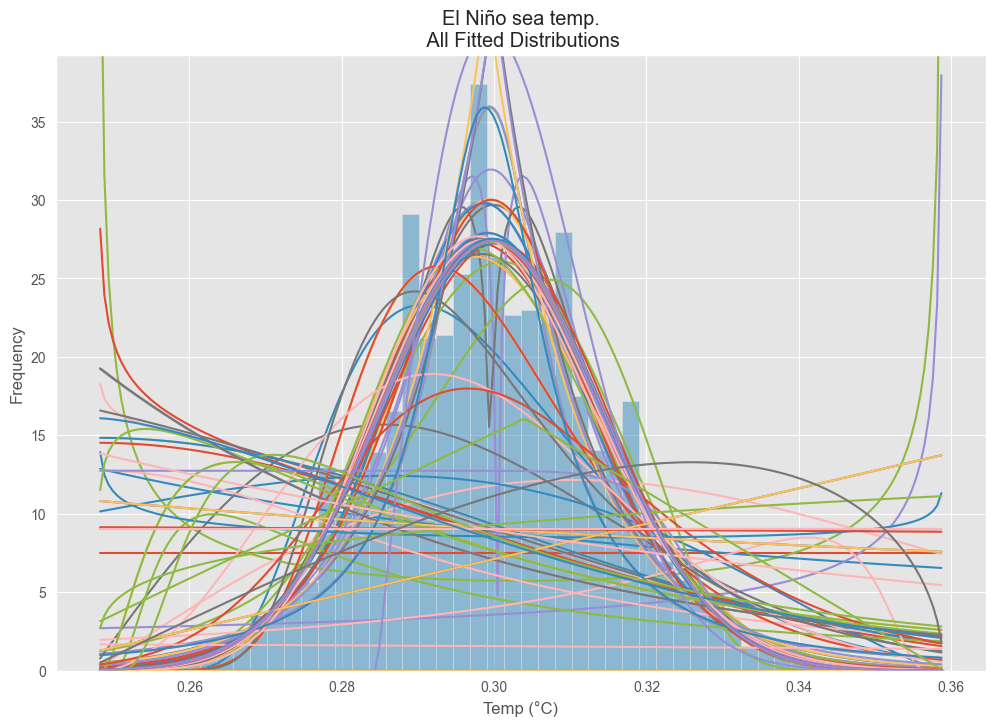

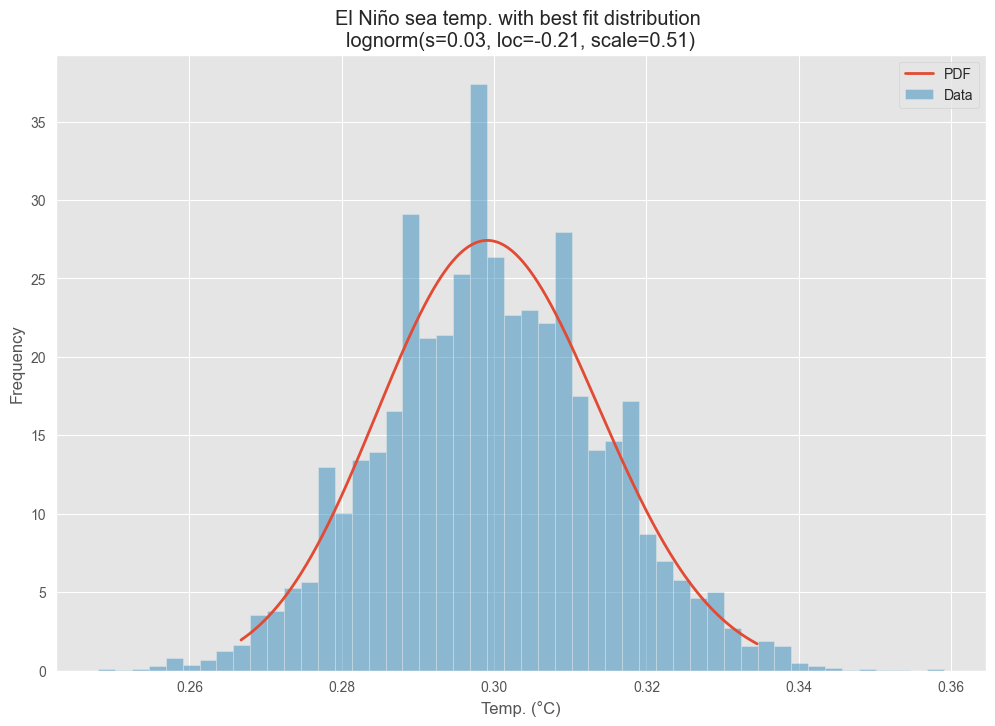

In [26]:
# CALCULATIONS
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])


def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


# Load data from statsmodels datasets
data = binomial_distribution_data

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12, 8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')